#Setup and Imports#

##PIP and imports##

In [ ]:
#Necessary pip installs
# %pip install s3fs
# %pip install h5py
%pip install yellowbrick
%pip install imbalanced_learn

In [ ]:
#Necessary import cell
import json
import math;
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd;
import pprint
import threading
import time

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import seaborn as sns;

from imblearn.over_sampling import SMOTE;

from sklearn.cluster import KMeans;
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA;
from sklearn.feature_selection import VarianceThreshold
from sklearn.mixture import GaussianMixture;
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from yellowbrick.cluster import KElbowVisualizer

# from matplotlib.animation import FuncAnimation

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

##Data Parsing and Handling##
Parkinson's Data

In [ ]:
# Load the files from the local drive for the time being.
from google.colab import files

uploaded = files.upload()

#if uploaded['pd_speech_features_datasingleheader.csv']
#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))

Saving pd_speech_features_datasingleheader.csv to pd_speech_features_datasingleheader.csv


In [ ]:
# Initialize the system and parse the data.
sns.set()
pandasFile = pd.read_csv('pd_speech_features_datasingleheader.csv');

ids = pandasFile['id'].to_numpy();
ids = np.reshape(ids, (ids.shape[0], 1));
originalFullDataFrame = pandasFile.drop('id', axis=1);  # Remove the patient ID.
xDataFrame = originalFullDataFrame.drop('class', axis=1);    # Remove the y value.
yDataFrame = originalFullDataFrame['class'];

columnHeaders = originalFullDataFrame.columns;

#Normalize X data: 
scaler = StandardScaler();
scaler.fit(xDataFrame);
xScaledNumPy = scaler.transform(xDataFrame);
xNumPy = xScaledNumPy; # xDataFrame.to_numpy();
yNumPy = yDataFrame.to_numpy();
yNumPy = np.reshape(yNumPy, (yNumPy.shape[0], 1));
originalFullNumPy = np.hstack((ids, xNumPy, yNumPy));

In [ ]:
#train, test = train_test_split(dataframe, test_size=0.2)
#train, val = train_test_split(train, test_size=0.2)


In [ ]:
#shape checks
print(originalFullNumPy.shape);
print(xNumPy.shape)
print(yNumPy.shape)

(756, 755)
(756, 753)
(756, 1)


In [ ]:
# Sort by 'class' (i.e., diseased/healthy).
classSortedNumPy = originalFullNumPy[np.argsort(originalFullNumPy[:, -1])];

# Find where the healthy/diseased boundary is.
splitIndex = -1;
for i in range(classSortedNumPy.shape[0]):
    if (1.0 == classSortedNumPy[i, -1]):
        splitIndex = i;
        break;

# Split into healthy vs. diseased.
healthyUnsortedNumPy = classSortedNumPy[0:splitIndex, :];
diseasedUnsortedNumPy = classSortedNumPy[splitIndex:, :];

healthySortedNumPy = np.random.shuffle(healthySortedNumPy)
healthySortedNumPy = healthyUnsortedNumPy[np.argsort(healthyUnsortedNumPy[:, 0])];  # Sort by ID so that all of a certain ID are grouped together.
healthySortedNumPy = healthySortedNumPy[:, 1:]; # Remove ID column.
healthyFullDataFrame = pd.DataFrame(healthySortedNumPy, columns=columnHeaders); # Create a DataFrame to retain headers.
healthyXDataFrame = healthyFullDataFrame.drop('class', axis=1); # Remove the 'class' column.
#healthyYDataFrame = healthyFullDataFrame.

# Lather, rinse, repeat for diseased.
diseasedSortedNumPy = np.random.shuffle(diseasedSortedNumPy)
diseasedSortedNumPy = diseasedUnsortedNumPy[np.argsort(diseasedUnsortedNumPy[:, 0])];
diseasedSortedNumPy = diseasedSortedNumPy[:, 1:];
diseasedFullDataFrame = pd.DataFrame(diseasedSortedNumPy, columns=columnHeaders);
diseasedXDataFrame = diseasedFullDataFrame.drop('class', axis=1);

# Calculate our counts for each sets.
testingRatio = 0.1;
validationRatio = 0.2;

# The strange arithmetic is meant to make sure that all of an individual's samples go together.
healthyTestingCount = math.floor((healthySortedNumPy.shape[0] / 3) * testingRatio) * 3;
healthyValidationCount = math.floor((healthySortedNumPy.shape[0] / 3) * validationRatio) * 3;
healthyTrainingCount = healthySortedNumPy.shape[0] - (healthyTestingCount + healthyValidationCount);

diseasedTestingCount = math.floor((diseasedSortedNumPy.shape[0] / 3) * testingRatio) * 3;
diseasedValidationCount = math.floor((diseasedSortedNumPy.shape[0] / 3) * validationRatio) * 3;
diseasedTrainingCount = diseasedSortedNumPy.shape[0] - (diseasedTestingCount + diseasedValidationCount);

# Split apart our sets.
healthyTrainingWOVSetNumPy = healthySortedNumPy[0:healthyTrainingCount, :];
healthyValidationSetNumPy = healthySortedNumPy[healthyTrainingCount:(healthyTrainingCount + healthyValidationCount)];
healthyTestingSetNumPy = healthySortedNumPy[(healthyTrainingCount + healthyValidationCount):, :];
healthyTrainingSetNumPy = np.vstack((healthyTrainingWOVSetNumPy, healthyValidationSetNumPy));

diseasedTrainingWOVSetNumPy = diseasedSortedNumPy[0:diseasedTrainingCount, :];
diseasedValidationSetNumPy = diseasedSortedNumPy[diseasedTrainingCount:(diseasedTrainingCount + diseasedValidationCount)];
diseasedTestingSetNumPy = diseasedSortedNumPy[(diseasedTrainingCount + diseasedValidationCount):, :];
diseasedTrainingSetNumPy = np.vstack((diseasedTrainingWOVSetNumPy, diseasedValidationSetNumPy));

# Reconstruct our training and testing sets (i.e., (healthy + diseased)x(training vs testing)).
trainingWOVSetNumPy = np.vstack((healthyTrainingWOVSetNumPy, diseasedTrainingWOVSetNumPy));
trainingWOVSetDataFrame = pd.DataFrame(trainingWOVSetNumPy, columns=columnHeaders);
validationSetNumPy = np.vstack((healthyValidationSetNumPy, diseasedValidationSetNumPy));
validationSetDataFrame = pd.DataFrame(validationSetNumPy, columns=columnHeaders);

trainingSetNumPy = np.vstack((healthyTrainingSetNumPy, diseasedTrainingSetNumPy));
trainingSetDataFrame = pd.DataFrame(trainingSetNumPy, columns=columnHeaders);
testingSetNumPy = np.vstack((healthyTestingSetNumPy, diseasedTestingSetNumPy));
testingSetDataFrame = pd.DataFrame(testingSetNumPy, columns=columnHeaders);

trainingWOVSetDataNumPy = trainingWOVSetNumPy[:, :-1];
trainingWOVSetLabelsNumPy = trainingWOVSetNumPy[:, -1];

validationSetDataNumPy = validationSetNumPy[:, :-1];
validationSetLabelsNumPy = validationSetNumPy[:, -1];

trainingSetDataNumPy = trainingSetNumPy[:, :-1];
trainingSetLabelsNumPy = trainingSetNumPy[:, -1];

testingSetDataNumPy = testingSetNumPy[:, :-1];
testingSetLabelsNumPy = testingSetNumPy[:, -1];

fullNumPy = np.vstack((trainingSetNumPy, testingSetNumPy));
fullXNumPy = fullNumPy[:, :-1];
fullYNumPy = fullNumPy[:, -1];
fullDataFrame = pd.DataFrame(fullNumPy, columns=columnHeaders);
fullXDataFrame = fullDataFrame.drop('class', axis=1);

In [ ]:
#Shape checks
print(f"{healthyTrainingCount} {healthyValidationCount} {healthyTestingCount}");
print(f"{diseasedTrainingCount} {diseasedValidationCount} {diseasedTestingCount}");
print(trainingWOVSetNumPy.shape);
print(validationSetNumPy.shape);
print(trainingSetNumPy.shape);
print(f"testingSetNumPy: {testingSetNumPy.shape}");
print(healthySortedNumPy.shape);
print(diseasedSortedNumPy.shape);
print(fullNumPy.shape)

138 36 18
399 111 54
(537, 754)
(147, 754)
(684, 754)
testingSetNumPy: (72, 754)
(192, 754)
(564, 754)
(756, 754)


#Unsupervised Learning#

AttributeError: ignored

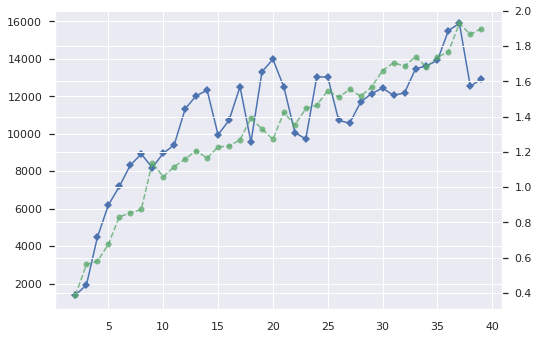

In [ ]:
#Elbow method for Kmeans:
model = KMeans(random_state=0);
visualizer = KElbowVisualizer(model, k=(2,40)); # k=(80,100))
visualizer.fit(xNumPy)        # Fit the data to the visualizer
visualizer.show()     

In [ ]:
clusterCount = 2;
model = KMeans(n_clusters=clusterCount);
model.fit(xNumPy);
kMeans9ClustersLabels = model.labels_;

clusterScores = np.zeros((clusterCount, 2));
for i in range(kMeans9ClustersLabels.shape[0]):
  clusterIndex = kMeans9ClustersLabels[i];
  healthIndex = yDataFrame[i];
  #print(clusterIndex);
  #print(healthIndex);
  clusterScores[clusterIndex, healthIndex] = np.add(clusterScores[clusterIndex, healthIndex], np.full((1), 1));

for i in range(clusterScores.shape[0]):
  ratio = clusterScores[i, 1] / (clusterScores[i, 0] + clusterScores[i, 1]);
  print(f"{clusterScores[i, 0]}, {clusterScores[i, 1]} = {ratio}");

154.0, 244.0 = 0.6130653266331658
38.0, 320.0 = 0.8938547486033519


In [ ]:
print(kMeans9Clusters.shape)

NameError: ignored

In [ ]:
pca170fullModel = PCA(n_components=170);
pca170fullModel.fit(xScaledNumPy); # healthyXDataFrame); # diseasedXDataFrame);
pca170fullXData = pca170fullModel.transform(xScaledNumPy);

In [ ]:
print(np.sum(pca170fullModel.explained_variance_ratio_))

0.9511612286442452


AttributeError: ignored

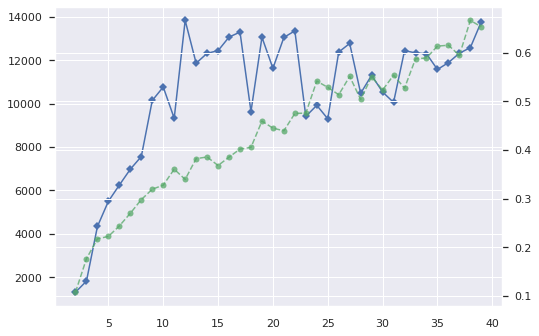

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=0);
visualizer = KElbowVisualizer(model, k=(2,40))

visualizer.fit(pca170fullXData)        # Fit the data to the visualizer
visualizer.show()     

In [ ]:
clusterCount = 6;
model = KMeans(n_clusters=clusterCount);
model.fit(pca170fullXData);
kMeans9ClustersLabels = model.labels_;

clusterScores = np.zeros((clusterCount, 2));
for i in range(kMeans9ClustersLabels.shape[0]):
  clusterIndex = kMeans9ClustersLabels[i];
  healthIndex = yDataFrame[i];
  #print(clusterIndex);
  #print(healthIndex);
  clusterScores[clusterIndex, healthIndex] = np.add(clusterScores[clusterIndex, healthIndex], np.full((1), 1));

for i in range(clusterScores.shape[0]):
  ratio = clusterScores[i, 1] / (clusterScores[i, 0] + clusterScores[i, 1]);
  print(f"{clusterScores[i, 0]}, {clusterScores[i, 1]} = {ratio}");

3.0, 6.0 = 0.6666666666666666
8.0, 148.0 = 0.9487179487179487
94.0, 59.0 = 0.38562091503267976
19.0, 107.0 = 0.8492063492063492
56.0, 185.0 = 0.7676348547717843
12.0, 59.0 = 0.8309859154929577


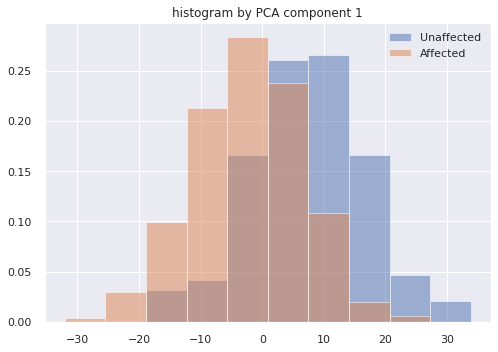

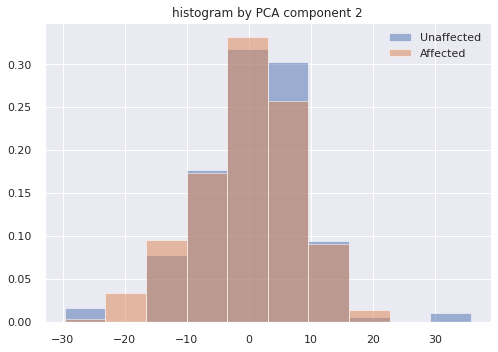

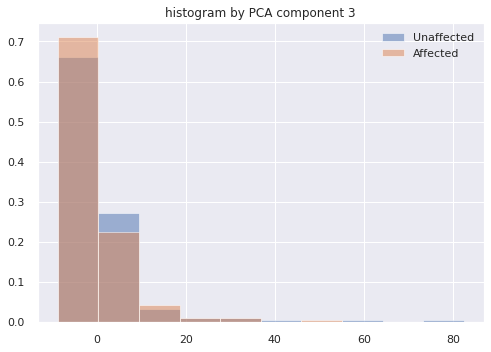

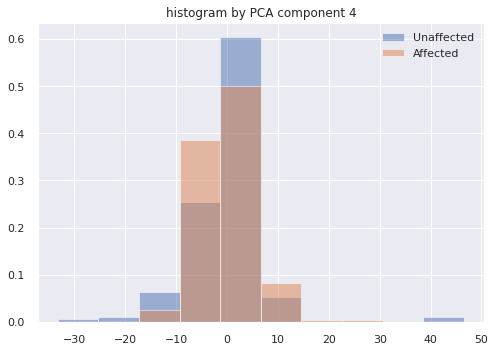

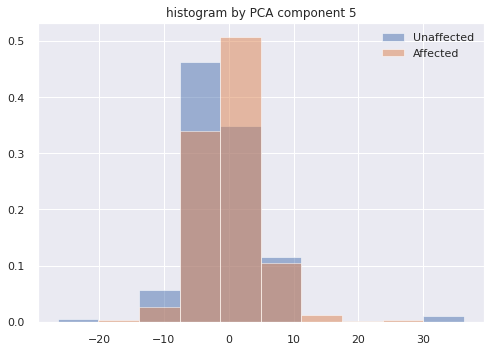

In [ ]:
# HISTOGRAMS OF TOP 5 PCA COMPONENTS:
pcaComponentCount = 5
pca5ModelGraphic = PCA(n_components=pcaComponentCount)
pca5ModelGraphic.fit(fullXDataFrame) #healthyXDataFrame) # diseasedXDataFrame)
graphicPointsHealthy = pca5ModelGraphic.transform(healthyXDataFrame)
graphicPointsDiseased = pca5ModelGraphic.transform(diseasedXDataFrame)
weightsHealthy = np.ones_like(graphicPointsHealthy[:,0])/192
weightsDiseased = np.ones_like(graphicPointsDiseased[:,0])/564

for pca_component in range(pcaComponentCount):
  binCount = 10
  diseasedComponent = graphicPointsDiseased[:, pca_component];
  healthyComponent = graphicPointsHealthy[:, pca_component];
  histComponents = [healthyComponent, diseasedComponent]
  rangeTuple = (min(np.min(diseasedComponent), np.min(healthyComponent)), max(np.max(diseasedComponent), np.max(healthyComponent)))
  #binWidth = math.ceil(max(np.max(diseasedComponent), np.max(healthyComponent)) - min(np.min(diseasedComponent), np.min(healthyComponent)) / width);

  #plt.hist(histComponents, 
  #        alpha=0.5, # the transaparency parameter
  #        label=['Unaffected', 'Affected'],
  #        bins = binCount) #binWidth)

  plt.hist(healthyComponent, 
          alpha=0.5, # the transaparency parameter
          label='Unaffected',
          weights = weightsHealthy,
          range = rangeTuple,
          bins = binCount) #binWidth)
    
  plt.hist(diseasedComponent,
          alpha=0.5,
          label='Affected',
          weights = weightsDiseased,
          range = rangeTuple,
          bins = binCount) # bins(graphicPointsHealthy[:,pca_component],width))
    
  plt.legend(loc='upper right')
  plt.title(f'histogram by PCA component {pca_component+1}')
  plt.show()

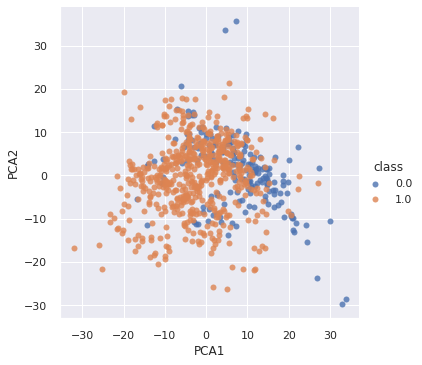

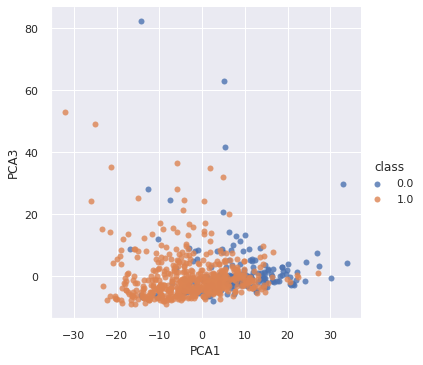

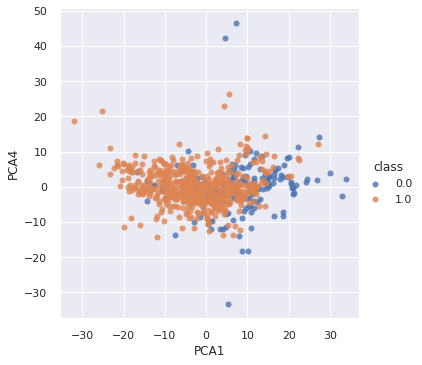

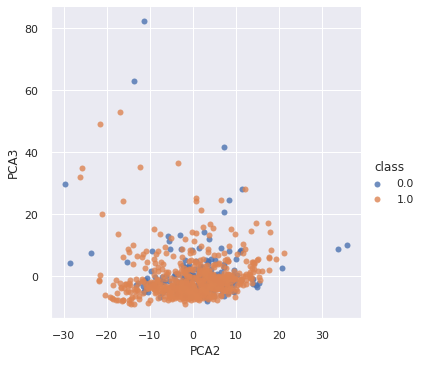

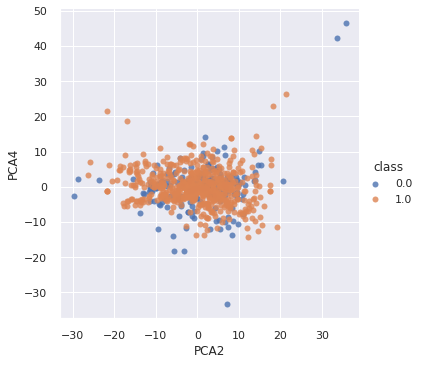

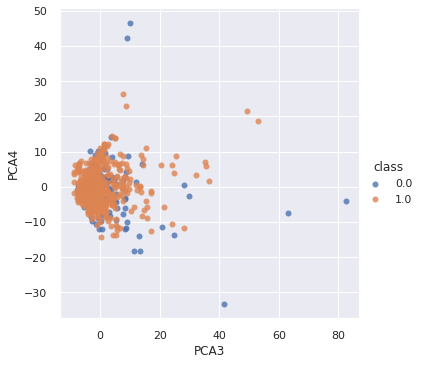

In [ ]:
pcaDiseasedDataSets = np.hstack((graphicPointsDiseased, np.full((graphicPointsDiseased.shape[0], 1), 1)));
pcaHealthyDataSets = np.hstack((graphicPointsHealthy, np.full((graphicPointsHealthy.shape[0], 1), 0)));

pcaDataSetsNumPy = np.vstack((pcaHealthyDataSets, pcaDiseasedDataSets));

biasedTraining = pd.DataFrame(pcaDataSetsNumPy, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'class']);
sns.lmplot(x="PCA1", y="PCA2", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA1", y="PCA3", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA1", y="PCA4", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA2", y="PCA3", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA2", y="PCA4", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA3", y="PCA4", hue='class', data=biasedTraining, fit_reg=False);

In [ ]:
print(np.sum(pca5ModelGraphic.explained_variance_ratio_))

0.3846116423606139


Try fitting on only healthy individuals

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans();
visualizer = KElbowVisualizer(model, k=(2,40))

visualizer.fit(pca80XData)        # Fit the data to the visualizer
visualizer.show()     

NameError: ignored

In [ ]:
clusterCount = 10;
model = KMeans(n_clusters=clusterCount);
model.fit(pca80XData);
kMeansPca80ClustersLabels = model.labels_;

clusterScores = np.zeros((clusterCount, 2));
for i in range(kMeansPca80ClustersLabels.shape[0]):
  clusterIndex = kMeansPca80ClustersLabels[i];
  healthIndex = yDataFrame[i];
  #print(clusterIndex);
  #print(healthIndex);
  clusterScores[clusterIndex, healthIndex] = np.add(clusterScores[clusterIndex, healthIndex], np.full((1), 1));

for i in range(clusterScores.shape[0]):
  ratio = clusterScores[i, 1] / (clusterScores[i, 0] + clusterScores[i, 1]);
  print(f"{clusterScores[i, 0]}, {clusterScores[i, 1]} = {ratio}");

NameError: ignored

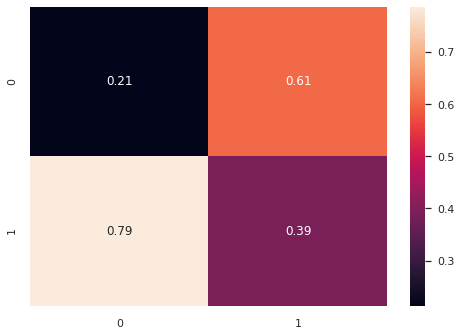

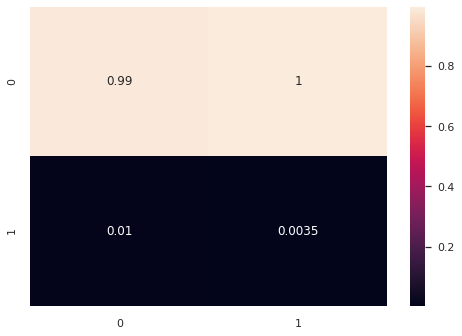

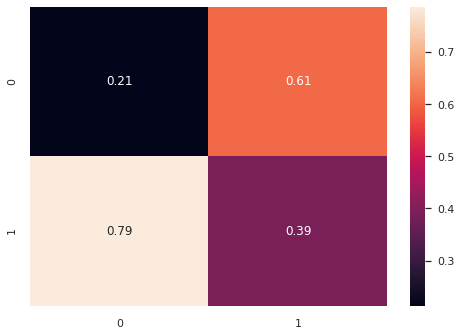

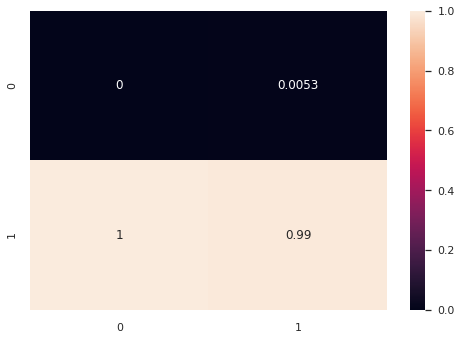

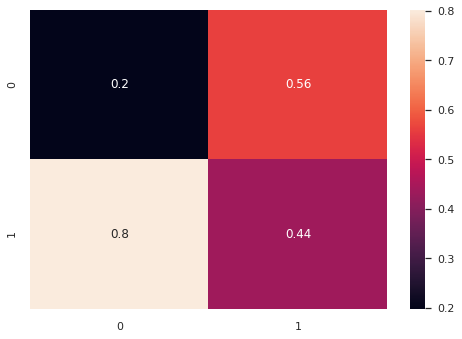

In [ ]:
#GMM confusion matrix heatmap, generated over several different trainings
for i in range(5):
  model = GaussianMixture(n_components=2)
  model.fit(pca170fullXData)
  gmmLabels = model.predict(pca170fullXData)
  cm = confusion_matrix(gmmLabels,yNumPy) / np.asarray([192,564])
  sns.heatmap(cm, annot=True)
  plt.show()

In [ ]:
#print(probs[:25].round(3))
#OLD MANUAL confusion matrix code
clusterScores = np.zeros((clusterCount, 10));
for i in range(gmmClusterLabels.shape[0]):
  clusterIndex = gmmClusterLabels[i];
  healthIndex = yDataFrame[i];
  #print(clusterIndex);
  #print(healthIndex);
  clusterScores[clusterIndex, healthIndex] = np.add(clusterScores[clusterIndex, healthIndex], np.full((1), 1));

for i in range(clusterScores.shape[0]):
  ratio = clusterScores[i, 1] / (clusterScores[i, 0] + clusterScores[i, 1]);
  print(f"{clusterScores[i, 0]}, {clusterScores[i, 1]} = {ratio}");

#plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

#print(gmm9ClustersLabels.shape)
#for i in range(5):
#  print(gmm9ClustersLabels[i]);

NameError: ignored

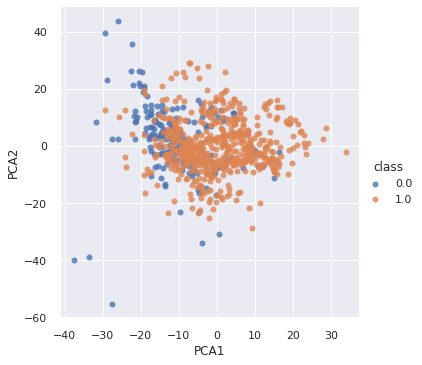

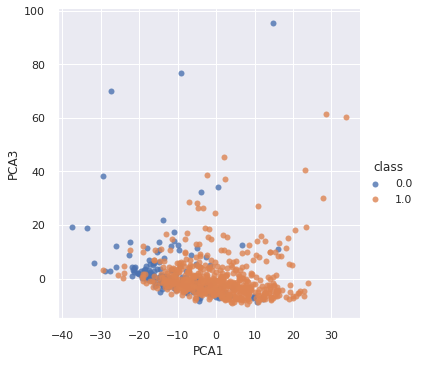

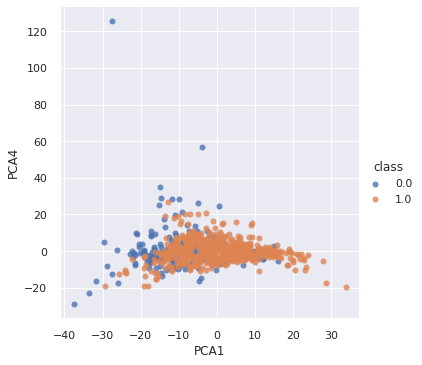

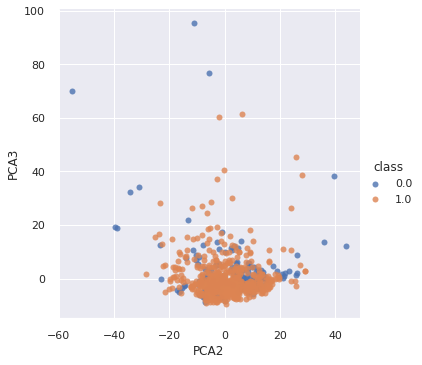

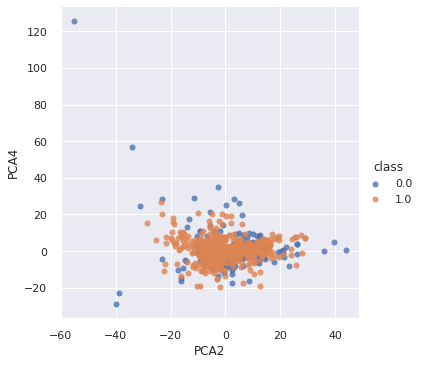

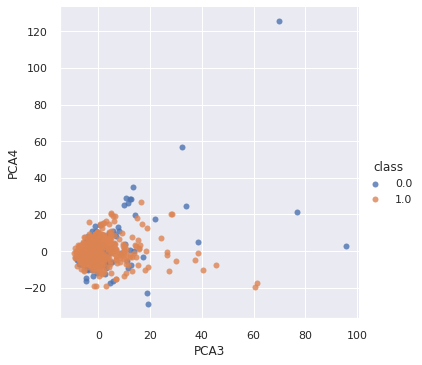

In [ ]:
# 2-component PCA Analysis (only diseased for fitting)
pcaModelDiseased2 = make_pipeline(StandardScaler(),PCA(n_components=4));
pcaModelDiseased2.fit(diseasedXDataFrame); #healthyXDataFrame);
pcaDiseasedDataSets = pcaModelDiseased2.transform(diseasedXDataFrame);
pcaHealthyDataSets = pcaModelDiseased2.transform(healthyXDataFrame);

pcaDiseasedDataSets = np.hstack((pcaDiseasedDataSets, np.full((pcaDiseasedDataSets.shape[0], 1), 1)));
pcaHealthyDataSets = np.hstack((pcaHealthyDataSets, np.full((pcaHealthyDataSets.shape[0], 1), 0)));

pcaDataSetsNumPy = np.vstack((pcaHealthyDataSets, pcaDiseasedDataSets));

biasedTraining = pd.DataFrame(pcaDataSetsNumPy, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'class']);
sns.lmplot(x="PCA1", y="PCA2", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA1", y="PCA3", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA1", y="PCA4", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA2", y="PCA3", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA2", y="PCA4", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA3", y="PCA4", hue='class', data=biasedTraining, fit_reg=False);
#pcaDataSet = pd.DataSet()

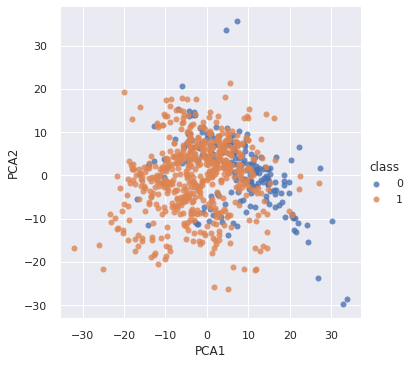

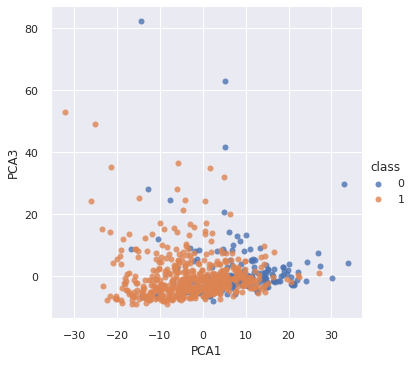

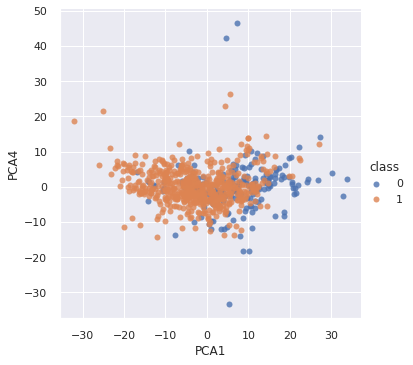

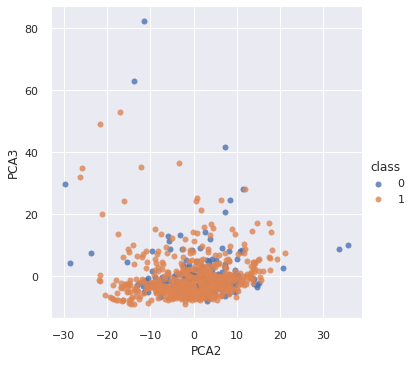

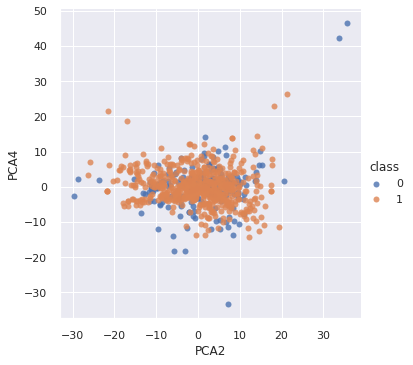

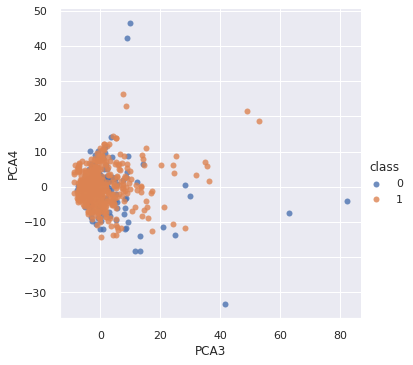

In [ ]:
# 4-component PCA Analysis
pcaModel4 = make_pipeline(StandardScaler(),PCA(n_components=4))            # 2. Instantiate the model with hyperparameters
pcaModel4.fit(xDataFrame)                      # 3. Fit to data. Notice y is not specified!
pcaDataSets = pcaModel4.transform(xDataFrame)         # 4. Transform the data to two dimensions

pandasFile['PCA1'] = pcaDataSets[:, 0]
pandasFile['PCA2'] = pcaDataSets[:, 1]
pandasFile['PCA3'] = pcaDataSets[:, 2]
pandasFile['PCA4'] = pcaDataSets[:, 3]
sns.lmplot(x="PCA1", y="PCA2", hue='class', data=pandasFile, fit_reg=False);
sns.lmplot(x="PCA1", y="PCA3", hue='class', data=pandasFile, fit_reg=False);
sns.lmplot(x="PCA1", y="PCA4", hue='class', data=pandasFile, fit_reg=False);
sns.lmplot(x="PCA2", y="PCA3", hue='class', data=pandasFile, fit_reg=False);
sns.lmplot(x="PCA2", y="PCA4", hue='class', data=pandasFile, fit_reg=False);
sns.lmplot(x="PCA3", y="PCA4", hue='class', data=pandasFile, fit_reg=False);

# Rats without Hats
### Contributors:
* [Justin Cropsey](https://github.com/jcropsey-gatech)
* [David Gordon](https://github.com/DavidCGordon)
* [Su Timurturkan](https://github.com/sutimurturkan)

## Summary Figure
![Project Infographic](Rats_with_Hats_Project_Poster.jpg)

## Introduction
Due to loss of team members and the complexity of the Allen Brain Observatory's data, we switched to Sohel Rana's [Parkinson's Disease Classification](https://www.kaggle.com/sohelranaccselab/parkinsons-disease-classification) (PDC) dataset on Kaggle.

[Parkinson's Disease](https://www.mayoclinic.org/diseases-conditions/parkinsons-disease/symptoms-causes/syc-20376055) (PD) is a progressive neurodegenerative disorder that is part of the Lewy Body Dementias umbrella that also includes [Dementia with Lewy Bodies](https://www.mayoclinic.org/diseases-conditions/lewy-body-dementia/symptoms-causes/syc-20352025) (DLB). As the name of the umbrella term implies, the defining characteristic of both disorders is the presence of Lewy bodies (plaques in the brain). While both disorders ultimately result in the same symptoms, the distinguisher between them is whether the tremor (PD) or another symptom appears first.

Like other diseases that plaques in the brain (e.g., Alzheimer's disease), biopsy is off limits due to the dangers associated with neurosurgery. While a form of single-photon emission computerized tomography (SPECT) scan called a dopamine-transporter scan (DaTscan) can assist in diagnosis, it is expensive. Our goal is to elaborate a minimally invasive, low-cost solution using speech characteristics and machine learning to aid in diagnosis of PD.

For our project, we will apply the unstructured learning techniques taught in this class to analyze over 750 dimensions of speech characteristics. Afterwards, we will apply structured learning techniques to the annotated datasets to be able to predict whether a patient exhibiting certain patterns of speech characteristics merits further evaluation for PD.

## Methods
The PDC dataset contains 754 different dimensions of data measuring various speech pathologies along with binary gender categorization. Each patient was sampled three times. There are 64 unaffected individuals and 188 affected individuals represented in the data set (756 samples total). No missing data points were observed in the data set. Following import, the data was split apart into various blocks (viz., headers, patient IDs, and X-Y data). The X-Y data (not including the disease classification (Y)) was scaled using Scikit-Learn's [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

    scaler = StandardScaler()
	scaler.fit(xDataFrame)
	xNumPy = scaler.transform(xDataFrame);

The X-Y data set was sorted based on disease classification (Y) and split into unaffected vs affected sets at the boundary. The two sets were subsequently individually split by a common ratio into training vs testing sets, yielding unaffected-training, unaffected-testing, affected-training, and affected-testing set, while ensuring that all samples of a particular patient went into either their respective training or testing set but not both.

A k-means elbow analysis in the range of k = \[4,40\] was performed on the entire data set using Yellowbrick's [K-Elbow Visualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html). Higher orders were examined in narrower ranges due to the increased processing time associated with higher orders.
	model = KMeans();
	visualizer = KElbowVisualizer(model, k=(2,40));

	visualizer.fit(xDataFrame)        # Fit the data to the visualizer
	visualizer.show()

A direct k-means analysis with k = 2 (from the elbow method) was performed on the scaled X data set. The number of representatives in each cluster were tabulated to determine which cluster represented which disease status.

A [Principal Component Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (PCA) was performed with Scikit-Learn's PCA() over the entire X data set. n was chosen to be 170 because that represented 95.1% of the variance observed in the data. Another k-means elbow analysis in the range of k = \[2, 40\] was performed on the PCA transformed data. Again k was chosen to be 2, and a k-means analysis performed.

Under the assumption that PD is a collection of diseases due to heterogeneity in the rates of degeneration across the various neuroanatomical regions in patients, the PCA and subsequent k-means analysis was performed again, but with the PCA only fitted over the unaffected or the affected subsets of X. (Transformation was performed across the entire data set.) The goal was to identify a well-defined cluster of one of the disease states and then define the other states as everything else (i.e., universe - cluster). Due to the high explained-variance ratio when fitting PCA to unaffected data alone, an additional k = 6 k-means analysis was performed.

A 2-component [Gaussian Mixture Model](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) (GMM) was iteratively run over the raw data set and the n=170 holistically-fitted PCA data set with [confusion matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) rendered with the goal being to identify matrices where one of the diagonals is much larger than the other.

Ten-bin [histograms](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) were prepared on a 5-component PCA analysis fitted to the full, unaffected, and affected data sets, respectively.

## Results
Because the data set is unbalanced in the number of affected vs unaffected individuals, a randomly selected sample from the data set has a 74.6% probability of being affected. In the tables presented below, we are searching for methods that have noticeable deviation from probability due to chance alone.

#### Fig. A1 - K-Means elbow analysis over entire scaled data set
![K-Means Elbow Analysis over Raw Data](raw_kmeans_elbow2_40.png)

#### Table B1 - Partitioning of unaffected vs affected into clusters by K-Means over entire scaled data set
| Unaffected | Affected | Ratio |
|----|----|----|
| 39 | 322 | 0.892 |
| 153 | 242 | 0.613 |

#### Fig. A2 - K-Means elbow analysis over 170-component PCA data fit to entire data set
![K-Means Elbow Analysis over PCA-170 Entire Data](pca170_kmeans_elbow2_40.png)

#### Table B2 - Partitioning of unaffected vs affected into clusters by K-Means over 170-component PCA data fit to entire data set
| Unaffected | Affected | Ratio |
|----|----|----|
| 38 | 320 | 0.894 |
| 154 | 244 | 0.613 |

#### Fig. A3 - K-Means elbow analysis over 170-component PCA data fit to affected data set
![K-Means Elbow Analysis over PCA-170 Affected Data](pca170_diseased_kmeans_elbow2_40.png)

#### Table B3 - Partitioning of unaffected vs affected into clusters by K-Means over 170-component PCA data fit to affected data set
| Unaffected | Affected | Ratio |
|----|----|----|
| 156 | 247 | 0.613 |
| 36 | 317 | 0.898 |

#### Fig. A4 - K-Means elbow analysis over 170-component PCA data fit to unaffected data set
![K-Means Elbow Analysis over PCA-170 Unaffected Data](pca170_healthy_kmeans_elbow2_40.png)

When the 170-component PCA was fitted to unaffected data, a 0.9984 explained variance was achieved.

##### Table B4 - Partitioning of unaffected vs affected into clusters by K-Means over 170-component PCA data fit to unaffected data set
| Unaffected | Affected | Ratio |
|----|----|----|
| 44 | 337 | 0.885 |
| 148 | 227 | 0.605 |

### K-Means Analysis (with k=6) over 170-component PCA fit to Unaffected Data

#### Table B5 - Partitioning of unaffected vs affected into clusters by K-Means (k=6) over 170-component PCA data fit to unaffected data set
| Unaffected | Affected | Ratio |
|----|----|----|
| 78 | 42 | 0.350 |
| 58 | 159 | 0.733 |
| 10 | 162 | 0.942 |
| 19 | 106 | 0.848 |
| 22 | 87 | 0.798 |
| 5 | 8 | 0.615 |

### Figs. A5 - Two-Component GMM on 170-component PCA fitted to the entire data set
![GMM Confusion Matrix 1](gmm_confusionmatrix_1.png)
![GMM Confusion Matrix 2](gmm_confusionmatrix_2.png)
![GMM Confusion Matrix 3](gmm_confusionmatrix_3.png)
![GMM Confusion Matrix 4](gmm_confusionmatrix_4.png)
![GMM Confusion Matrix 5](gmm_confusionmatrix_5.png)

### Figs. A6 - Five-Component PCA Fitted to Full Data Set
![PCA Component 2 vs. PCA Component 1](full_pca5_1_2.png)
![PCA Component 3 vs. PCA Component 1](full_pca5_1_3.png)
![PCA Component 4 vs. PCA Component 1](full_pca5_1_4.png)
![PCA Component 3 vs. PCA Component 2](full_pca5_2_3.png)
![PCA Component 4 vs. PCA Component 2](full_pca5_2_4.png)
![PCA Component 4 vs. PCA Component 3](full_pca5_3_4.png)

### Figs. A7 - Five-Component PCA Fitted to Affected Data Set
![PCA Component 2 vs. PCA Component 1](affected_pca5_1_2.png)
![PCA Component 3 vs. PCA Component 1](affected_pca5_1_3.png)
![PCA Component 4 vs. PCA Component 1](affected_pca5_1_4.png)
![PCA Component 3 vs. PCA Component 2](affected_pca5_2_3.png)
![PCA Component 4 vs. PCA Component 2](affected_pca5_2_4.png)
![PCA Component 4 vs. PCA Component 3](affected_pca5_3_4.png)

### Figs. A8 - Five-Component PCA Fitted to Unaffected Data Set
![PCA Component 2 vs. PCA Component 1](unaffected_pca5_1_2.png)
![PCA Component 3 vs. PCA Component 1](unaffected_pca5_1_3.png)
![PCA Component 4 vs. PCA Component 1](unaffected_pca5_1_4.png)
![PCA Component 3 vs. PCA Component 2](unaffected_pca5_2_3.png)
![PCA Component 4 vs. PCA Component 2](unaffected_pca5_2_4.png)
![PCA Component 4 vs. PCA Component 3](unaffected_pca5_3_4.png)

### Figs. A9 - Ten-Bin Histogram of 5-Component PCA Fitted to Full Data Set
![Histogram of PCA Component 1](hist10_full_component1.png)
![Histogram of PCA Component 2](hist10_full_component2.png)
![Histogram of PCA Component 3](hist10_full_component3.png)
![Histogram of PCA Component 4](hist10_full_component4.png)
![Histogram of PCA Component 5](hist10_full_component5.png)

### Figs. A10 - Ten-Bin Histogram of 5-Component PCA Fitted to Affected Data Set
![Histogram of PCA Component 1](hist10_affected_component1.png)
![Histogram of PCA Component 2](hist10_affected_component2.png)
![Histogram of PCA Component 3](hist10_affected_component3.png)
![Histogram of PCA Component 4](hist10_affected_component4.png)
![Histogram of PCA Component 5](hist10_affected_component5.png)

### Figs. A11 - Ten-Bin Histogram of 5-Component PCA Fitted to Unaffected Data Set
![Histogram of PCA Component 1](hist10_unaffected_component1.png)
![Histogram of PCA Component 2](hist10_unaffected_component2.png)
![Histogram of PCA Component 3](hist10_unaffected_component3.png)
![Histogram of PCA Component 4](hist10_unaffected_component4.png)
![Histogram of PCA Component 5](hist10_unaffected_component5.png)

## Discussion
The most obvious problems with our data are the presence of numerous outliers, and the amount of overlap of affected and unaffected individuals. This is most salient from the K-Means "elbow" plots (Figures A1, A2, A3, and A4), which resemble nothing like what an elbow plot should.

As noted in the Results, the data set is biased towards affected individuals by almost 3:1. K-means alone was able to do better than random chance by 17.8% and 19.6% unaffected vs affected respectively.

The 170-component PCA had lackluster performance in improving the categorization of data relative to a simple K-means clustering on scaled data (0.613:0.894 vs 0.613:0.892). Ironically, fitting the 170-component PCA to only the unaffected data improved the amount of explained variance (99.84% vs 95.1%) but had little impact on the categorization (0.605:0.885 vs 0.613:0.892). This evidences the belief that unaffected individuals constitute a "cloud" whereas affected individuals are outliers.

Table B6 with the results of the 6-cluster K-means analysis over the 170-component PCA data fitted to the unaffected data set provides a counter argument to this belief with due to its above average clustering of affected individuals. As noted in the Introduction, PD is a collection of diseases depending on which nuclei are affected and their respective severities.

Gaussian Mixture Modeling provided interesting results: The results were non-probabilistic (i.e., most entries were classified into a single cluster). In other words, it reduced itself to K-mean. Figures A5 show the confusion matrix resulting from GMM. While we did see the some of the desired results of one of the diagonals being much stronger than the other, given the nature of implications, none of them reached a level where we would feel confident enough to use them for this problem.

Figures A6, A7, and A8 are scatter plots of the various PCA components against each other. They serve to ellucidate the problem with the data overlapping. (The opacity was not attenuated with these graphs, and thus, the orange conceals some of the blue points.)

Figures A9, A10, and A11 are 10-bin histograms of 170-component PCA data fitted to the entire, affected, and unaffected data sets, respectively. When fit to the full data set, the primary PCA component exhibits the most distinction between the two disease states. However, when fit to a biased disease state, higher-order components do contribute to the distinction.

Fitting the PCA to the affected state produced some interesting results: The primary component showed more spread compared to the unaffected group, evidencing that PD is a collection of diseases. The secondary component showed a rightward shift in the affected group. The higher-order components do show additional differences, but not as significant as the lower-order components.

Fitting the PCA to the unaffected state also produced some interesting results: There are distinct shifts in the affected group relative to the unaffected group. Components 1 and 5 show a concentrating effect, which is to be expected with a neuromuscular disease like PD and its loss of fluidity of movement.

DBSCAN was also performed on the data but failed to produce anything more than random and thus is not included in the Results.

## References
[Prediction of Parkinson's disease using speech signal with Extreme Learning Machine](https://ieeexplore.ieee.org/abstract/document/7755419?casa_token=1aO88moUx48AAAAA:ub2CWrt38kw_ULeQK_zidk_ZMNRbEiTi9nNxtUOa3BNBoEbGqBD4UvQZ3cha4Od7-JtjG-i6)

[Parkinson’s Disease Diagnosis in Cepstral Domain Using MFCC
and Dimensionality Reduction with SVM Classifier](https://www.hindawi.com/journals/misy/2021/8822069/)

[LSTM Siamese Network for Parkinson’s Disease Detection
from Speech](https://ieeexplore.ieee.org/abstract/document/8969430?casa_token=IgSUTOkHeJoAAAAA:7DZe463IBhOllBG6uAAlPxUdaIbt9q0qRaykNNijhjD-xXcyW3Ks4WBwwozB8DnbAiL2IZA9)

[Collection and Analysis of a Parkinson Speech Dataset With Multiple Types of Sound Recordings](https://www.researchgate.net/publication/260662600_Collection_and_Analysis_of_a_Parkinson_Speech_Dataset_With_Multiple_Types_of_Sound_Recordings)


# Relic Code to Gaslight Su #

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

# Fit to data and predict using pipelined scaling, GNB and PCA.
Y = yDataFrame
X = xDataFrame

X_train,X_test ,Y_train,Y_test = train_test_split(X,Y,test_size=0.1, random_state=7)
scaled_model = make_pipeline(StandardScaler(), PCA(n_components=2), GaussianNB())
scaled_model.fit(X_train, Y_train)
pred_test_std = std_clf.predict(X_test)

NameError: ignored

In [ ]:
from sklearn import mixture

i = 0;
j = 1;
X = bothDataSetsNumPy[:, (i, j)];
gmm = make_pipeline(StandardScaler(),mixture.GaussianMixture(n_components=2, covariance_type='full')).fit(X);
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
#for i in range(5):
#  for j in range(i + 1, 5):


In [ ]:
print(bothDataSetsNumPy.shape)

In [ ]:
#DBSCAN Trials
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=20, min_samples=50).fit(pca80XData); # fullXNumPy)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
labelSet = set(labels);

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(labelSet) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

clusteredDiseased = 0;
clusteredHealthy = 0;
noiseDiseased = 0;
noiseHealthy = 0;
for i in range(labels.shape[0]):
  if 0 == yNumPy[i]:
    if -1 == labels[i]:
      noiseHealthy = noiseHealthy + 1;
    else:
      clusteredHealthy = clusteredHealthy + 1;
  else:
    if -1 == labels[i]:
      noiseDiseased = noiseDiseased + 1;
    else:
      clusteredDiseased = clusteredDiseased + 1;

print(f'Clustered: {clusteredHealthy} healthy vs. {clusteredDiseased} diseased');
print(f'Noise: {noiseHealthy} healthy vs. {noiseDiseased} diseased');

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(fullYNumPy, labels))
print("Completeness: %0.3f" % metrics.completeness_score(fullYNumPy, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(fullYNumPy, labels))
print("Adjusted Rand Index: %0.3f" \
      % metrics.adjusted_rand_score(fullYNumPy, labels))
#print("Adjusted Mutual Information: %0.3f" \
#      % metrics.adjusted_mutual_info_score(fullYNumPy, labels))
#print("Silhouette Coefficient: %0.3f" \
#      % metrics.silhouette_score(fullXNumPy, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = pca80XData[class_member_mask & core_samples_mask]
    if (0 != xy.shape[0]):
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=14)

    xy = pca80XData[class_member_mask & ~core_samples_mask]
    if (0 != xy.shape[0]):
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
# from sklearn.manifold import Isomap
# iso = Isomap(n_components=2)

# frameCount = data.shape[0]
# framesFlattened = np.zeros((frameCount, 512*512))
# for i in range(frameCount):
#   framesFlattened[i, :] = data[i, :, :].flatten();
# iso.fit(framesFlattened)
# data_projected = iso.transform(framesFlattened)
# data_projected.shape

In [ ]:
# plt.scatter(data_projected[:, 0], data_projected[:, 1], c=range(frameCount),
#             edgecolor='none', alpha=0.5,
#             cmap=plt.cm.get_cmap('Spectral', 10))
# plt.colorbar(label='digit label', ticks=range(10))
# plt.clim(-0.5, 9.5);

In [ ]:
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split

Y = yDataFrame
X = xDataFrame

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 12)

best_score = 0
# for n_neighbors in range(,):
#    for n_components in range(,):
#        isomap = Isomap(n_neighbors = n_neighbors, n_components = n_components)
#       isomap.fit(x_train)
#        x_train2 = isomap.transform(x_train)
#        x_test2 = isomap.transform(x_test)
#    for C in np.arange(0.05, 2, 0.05):
#        for gamma in np.arange(0.001, 0.1, 0.001):
#                model = SVC(C = C, gamma = gamma)
#               model.fit(x_train2, y_train)
#                score = model.score(x_test2, y_test)
#                if score > best_score:
#                    best_score = score
print ('Best score: ', best_score)

Best score:  0


# Supervised Learning #

In [ ]:
varThresholdP = 0.8;
varThresholdModel = VarianceThreshold(threshold=(varThresholdP * (1 - varThresholdP)))
varThresholdTransformedData = varThresholdModel.fit_transform(xScaledNumPy);
print(varThresholdTransformedData.shape);

(756, 753)


In [ ]:
gnbModel = GaussianNB();
gnbPredictions = gnbModel.fit(trainingSetDataNumPy, trainingSetLabelsNumPy).predict(testingSetDataNumPy);
gnbMislabeling = (testingSetLabelsNumPy != gnbPredictions).sum();
print("Number of mislabeled points out of a total %d points : %d (%f)" % (testingSetDataNumPy.shape[0], gnbMislabeling, 1 - (gnbMislabeling / testingSetDataNumPy.shape[0])));

Number of mislabeled points out of a total 72 points : 22 (0.694444)


In [ ]:
pcaKerasHealthyTrainedModel = PCA(n_components=100);
pcaKerasHealthyTrainedModel.fit(healthySortedNumPy);
pcaKerasHealthyTrainingData = pcaKerasHealthyTrainedModel.transform(trainingSetNumPy);
pcaKerasHealthyValidationData = pcaKerasHealthyTrainedModel.transform(validationSetNumPy);
pcaKerasHealthyTestingData = pcaKerasHealthyTrainedModel.transform(testingSetNumPy);

pcaKerasHealthyFullData = np.vstack((pcaKerasHealthyTrainingData, pcaKerasHealthyValidationData, pcaKerasHealthyTestingData));

In [ ]:
print(f"Normal: training: {trainingSetDataNumPy.shape}; validation: {validationSetDataNumPy.shape}; testing: {testingSetDataNumPy.shape}");
print(f"Keras-Healthy: training: {pcaKerasHealthyTrainingData.shape}; validation: {pcaKerasHealthyValidationData.shape}; testing: {pcaKerasHealthyTestingData.shape}");

Normal: training: (684, 753); validation: (147, 753); testing: (72, 753)
Keras-Healthy: training: (684, 100); validation: (147, 100); testing: (72, 100)


In [ ]:
def bin_data(data, premultiplier = 1):
  """ 
    Premultiplier is used to increase the number of discrete categories. For example, premultiplier = 2 doubles the number of categories.
  """
  data = data * premultiplier
  abs = np.absolute(data);  # Flip everything to positive so that floor works correctly.
  signs = data / abs;  # Preserve our signs
  binned = np.floor(abs);
  return signs * binned;

In [ ]:
premultiplier = 4;
binnedTrainingSetDataNumPy = bin_data(trainingSetDataNumPy, premultiplier);
binnedTestingSetDataNumPy = bin_data(testingSetDataNumPy, premultiplier);

postpcaScaler = StandardScaler();
postpcaScaler.fit(np.vstack((pcaKerasHealthyTrainingData, pcaKerasHealthyValidationData, pcaKerasHealthyTestingData)));

binnedPcaKerasHealthyTrainingData = bin_data(postpcaScaler.transform(pcaKerasHealthyTrainingData), premultiplier)
binnedPcaKerasHealthyValidationData = bin_data(postpcaScaler.transform(pcaKerasHealthyValidationData), premultiplier);
binnedPcaKerasHealthyTestingData = bin_data(postpcaScaler.transform(pcaKerasHealthyTestingData), premultiplier)

# print(binnedTrainingSetDataNumPy[10:100, 0:10]);

In [ ]:
# baseline model
def create_baseline():
    # create model
    model = Sequential();
    model.add(Dense(20, input_dim = 100, activation = 'relu'));
    #model.add(Dense(188, activation = 'sigmoid'));
    #model.add(Dense(5, activation = 'sigmoid'));
    model.add(Dense(1, activation = 'sigmoid'));
    # Compile model
    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='rmsprop'); # 'rmsprop',
    return model;

In [ ]:
print(trainingSetDataNumPy.shape)
print(trainingSetLabelsNumPy.shape)
print(testingSetDataNumPy.shape)
print(testingSetLabelsNumPy.shape)

Xtraining = binnedPcaKerasHealthyTrainingData
Xvalidation = binnedPcaKerasHealthyValidationData
Xtesting = binnedPcaKerasHealthyTestingData
y = trainingSetLabelsNumPy

print(Xtraining.shape);
print(Xtesting.shape);
print(y.shape);

(684, 753)
(684,)
(72, 753)
(72,)
(684, 100)
(72, 100)
(684,)


In [ ]:
X = trainingSetDataNumPy
y = trainingSetLabelsNumPy
oversampler = SMOTE()
X, y = oversampler.fit_resample(X, y)
#print(X.shape)
#print(y.shape)


model = Sequential([
    Dense(100, input_dim = X.shape[1], activation='sigmoid'),
    Dense(80, activation='sigmoid'),
    Dense(70, activation='sigmoid'),
    Dense(60, activation='sigmoid'),
    Dense(50, activation='sigmoid'),
    Dense(40, activation='sigmoid'),
    Dense(30, activation='sigmoid'),
    Dense(20, activation='sigmoid'),
    Dense(10, activation='sigmoid'),
    Dense(1, activation='sigmoid')
]);
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam'); 
model.fit(X,
          y,
          epochs = 600,
          validation_split = 0.1
          #validation_data = (Xvalidation, testingSetLabelsNumPy.reshape(-1, 1))
          )

scores = model.predict(testingSetDataNumPy)
predicted = np.round(scores)
print(list(scores))
actual = testingSetLabelsNumPy
print(actual)

print(classification_report(actual, testDataPredicted))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/600
29/29 [==============================] - 2s 20ms/step - loss: 0.6936 - accuracy: 0.4936 - val_loss: 0.8117 - val_accuracy: 0.0000e+00
Epoch 2/600
29/29 [==============================] - 0s 4ms/step - loss: 0.6884 - accuracy: 0.5494 - val_loss: 0.8426 - val_accuracy: 0.0000e+00
Epoch 3/600
29/29 [==============================] - 0s 5ms/step - loss: 0.6875 - accuracy: 0.5550 - val_loss: 0.8039 - val_accuracy: 0.0000e+00
Epoch 4/600
29/29 [==============================] - 0s 5ms/step - loss: 0.6822 - accuracy: 0.5781 - val_loss: 0.8029 - val_accuracy: 0.0000e+00
Epoch 5/600
29/29 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.5351 - val_loss: 0.8028 - val_accuracy: 0.0000e+00
Epoch 6/600
29/29 [==============================] - 0s 5ms/step - loss: 0.6764 - accuracy: 0.5544 - val_loss: 0.7691 - val_accuracy: 0.0000e+00
Epoch 7/600
29/29 [==============================] - 0s 5ms/step - loss: 0.6231 - accuracy: 0.6366 - val_loss: 0.6176 - val_accur

In [ ]:
#print(classification_report(testingSetLabelsNumPy, testDataPredicted))
testDataPredictedInts = testDataPredicted.astype(int);
testingSetLabelsNumPyInts = np.reshape(testingSetLabelsNumPy.astype(int), (testingSetLabelsNumPy.shape[0], 1));
predictedVsActual = np.logical_xor(testDataPredicted, testingSetLabelsNumPyInts);
errorCount = np.sum(predictedVsActual);
total = predictedVsActual.shape[0];
errorRate = errorCount / total;
print(f"{total - errorCount} out of total categorized correctly. Accuracy: {1 - errorRate}");


53 out of total categorized correctly. Accuracy: 0.7361111111111112


In [ ]:
#print(testDataPredictedInts);
#print(testingSetLabelsNumPyInts);
print(predictedVsActual);

[[ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]]


In [ ]:
print(trainingSetDataNumPy.shape)
print(trainingSetLabelsNumPy.shape)
print(testingSetDataNumPy.shape)
print(testingSetLabelsNumPy.shape)

model = create_baseline();
model.fit(x = pcaKerasHealthyTrainingData,
          y = trainingWOVSetLabelsNumPy.reshape(-1,1),
          epochs = 25,
          validation_data = (pcaKerasHealthyValidationData, validationSetLabelsNumPy.reshape(-1, 1))
          #validation_split = 0.1
          )

(684, 753)
(684,)
(72, 753)
(72,)


ValueError: ignored

In [ ]:
loss, accuracy = model.evaluate(
    x = pcaKerasHealthyTestingData,
    y = testingSetLabelsNumPy.reshape(-1,1));
print("Accuracy", accuracy)

estimator = KerasClassifier(build_fn=create_baseline, epochs=10, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, pcaKerasHealthyFullData, yNumPy, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

3/3 [==============================] - 1s 4ms/step - loss: 1.5930 - accuracy: 0.2713
Accuracy 0.2222222238779068


ValueError: ignored

In [ ]:
kerasHealthyTrainedPredictions = model.predict(pcaKerasHealthyTestingData);
kerasHealthyPredictionsMatrix = np.zeros((2, 2)); # (predicted, actual)

for i in range(kerasHealthyTrainedPredictions.shape[0]):
  predictionIndex = round(kerasHealthyTrainedPredictions[i][0]);
  actualIndex = int(testingSetLabelsNumPy[i]);
  #print(predictionIndex);
  #print(actualIndex);
  kerasHealthyPredictionsMatrix[predictionIndex, actualIndex] += 1; # np.add(kerasHealthyPredictionsMatrix[clusterIndex, healthIndex], np.full((1), 1));

for i in range(kerasHealthyPredictionsMatrix.shape[0]):
  ratio = kerasHealthyPredictionsMatrix[i, 1] / (kerasHealthyPredictionsMatrix[i, 0] + kerasHealthyPredictionsMatrix[i, 1]);
  print(f"{kerasHealthyPredictionsMatrix[i, 0]}, {kerasHealthyPredictionsMatrix[i, 1]} = {ratio}");

print()

NameError: ignored

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = trainingSetDataNumPy
y = trainingSetLabelsNumPy

oversampler = SMOTE()
X,y = oversampler.fit_resample(X,y)

model = RandomForestClassifier(criterion='entropy')
model.fit(X, y)

predicted = model.predict(testingSetDataNumPy)
print(predicted)
actual = testingSetLabelsNumPy
print(actual)

print(classification_report(actual, predicted))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
              precision    recall  f1-score   support

         0.0       0.50      0.61      0.55        18
         1.0       0.86      0.80      0.83        54

    accuracy                           0.75        72
   macro avg       0.68      0.70      0.69        72
weighted avg       0.77      0.75      0.76        72



#Supervised Learning Report#

### Supervised

For a baseline, a Scikit-Learn Gaussian Naive Bayes was performed.

Due to the overlapping nature of the two categories of data, it was decided to go directly to a neural net (NN) for the next efforts. Keras and TensorFlow were selected as the frameworks.

We experimented with various configurations of NNs, starting with a sequential three-layer NN on grouped-by-individual raw data. In one such configuration, layers were dense and consisted of 188, 4, and 1 neuron(s) per layer respectively, each with sigmoid activation.

Oscillations in the accuracy during training were observed and were traced back to unnormalized data. After fixing this with StandardScaler(), we achieved 100% accuracy on the training data after relatively few epochs, indicating overfitting. After reducing the number of epochs, various combinations of number of layers, density of each layer, activations (rectified linear uint (ReLU) and sigmoid), and epochs were explored.

To compensate for bias in the data set due to the overrepresentation of affected individuals, unaffected individuals were oversampled via [Synthetic Minority Oversampling Technique (SMOTE)](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html).

A 100-component PCA transform was fitted to unaffected, original-representation data and then feed into the NN. Again, various combinations of layer count, layer density, activations, and epochs were explored.

Adding a $validation\_split$ argument to the $fit()$ was also explored, but ultimately rejected, as it was found to "leak" testing data into the training set, giving inflated accuracy numbers. We replaced this with a custom implemented validation split, which kept samples from the same individual together in the training and testing sets. 

A Random Forest was performed using Scikit-Learn. Various combinations of maximum depth, criterion, features, and number of estimators were explored.

### Supervised

The Gaussian Naive Bayes achieved an accuracy of approximately 69% on the testing data set.

Despite the numerous combinations of setups, Keras and TensorFlow consistently achieved 72% +/- 2% on testing data.

The Random Forest achieved a weighted average 75% on the accuracy.

### Supervised

All of the methods we attempted yielded similar results.

Gaussian Naive Bayes, at 69% accuracy, was 5% below the intrinsic bias of the data set (74.6%).

Keras and TensorFlow provided equally unimpressive results despite the various combinations of setups. Even though most setups were able to achieve 100% accuracy, they achieved sub intrinsic bias scores on the testing data.

Preprocessing the data with PCA also yielded lackluster results due to the low explained variance even for 100-component transformation.

To our disappointment, compensating with SMOTE had no effect, despite being performed only on the training data, and ultimately yielded already represented individuals.

We were initially enthusiastic with adding $validation\_split$ to the NN because it achieved approximately 95% accuracy on both training and validation. Testing on the testing data set, however, achieved average results. We subsequently realized this was because of the triplicate nature of our data set: The validation data set was in effect a subset of the training data set and thus was already known to the NN. This confirmed our suspicion that maintaining all of an individual's samples in the same grouping (viz., training, validation, or testing) was the appropriate way to handle multiple samples from the same individual. In other words, the intraperson variance is smaller than the interperson variance.

A subsequent comparison of predicted vs. actual categorization sorted by individual revealed that, while single and double failures do happen, many failures tended to happen in triples as would be expected with triplicate data. The system simply could not accurately classify a constellation of symptoms it had never observed before.

The Random Forest did not realize any better results because it was encountering the same problems as the NN.

What was ultimately realized is that (1) there is a lot of diversity in the manifestation of symptoms with PD, and (2) the data set used was simply too small to capture this diversity.

There are two lights at the end of the tunnel: The first is that this is a very solvable problem with machine learning given the high accuracy achieved on already seen data. It simply needs to have experienced an individual with a similiar manifestation. The second, alternative approach is that it should be possible to pair down the fields to a subset of significant ones and then score how differently a sample is from "normal".

# Rats without Hats
### Contributors:
* [Justin Cropsey](https://github.com/jcropsey-gatech)
* [David Gordon](https://github.com/DavidCGordon)
* [Su Timurturkan](https://github.com/sutimurturkan)

## Summary Figure
![Project Infographic](Rats_with_Hats_Project_Poster.jpg)

## Introduction
Due to loss of team members and the complexity of the Allen Brain Observatory's data, we switched to Sohel Rana's [Parkinson's Disease Classification](https://www.kaggle.com/sohelranaccselab/parkinsons-disease-classification) (PDC) dataset on Kaggle.

[Parkinson's Disease](https://www.mayoclinic.org/diseases-conditions/parkinsons-disease/symptoms-causes/syc-20376055) (PD) is a progressive neurodegenerative disorder that is part of the Lewy Body Dementias umbrella that also includes [Dementia with Lewy Bodies](https://www.mayoclinic.org/diseases-conditions/lewy-body-dementia/symptoms-causes/syc-20352025) (DLB). As the name of the umbrella term implies, the defining characteristic of both disorders is the presence of Lewy bodies (plaques in the brain). While both disorders ultimately result in the same symptoms, the distinguisher between them is whether the tremor (PD) or another symptom appears first (DLB).

Like other diseases that caused by plaques in the brain (e.g., Alzheimer's disease), biopsy is off limits due to the dangers associated with neurosurgery. While a form of single-photon emission computerized tomography (SPECT) scan called a dopamine-transporter scan (DaTscan) can assist in diagnosis, it is expensive. Our goal is to elaborate a minimally invasive, low-cost solution using speech characteristics and machine learning to aid in diagnosis of PD.

For our project, we will apply the unstructured learning techniques taught in this class to analyze over 750 dimensions of speech characteristics. Afterwards, we will apply structured learning techniques to the annotated datasets to be able to predict whether a patient exhibiting certain patterns of speech characteristics merits further evaluation for PD.

## Methods
The PDC dataset contains 754 different dimensions of data measuring various speech pathologies along with binary gender categorization. Each patient was sampled three times. There are 64 unaffected individuals and 188 affected individuals represented in the data set (756 samples total). No missing data points were observed in the data set. Following import, the data was split apart into various blocks (viz., headers, patient IDs, and X-Y data). The X-Y data (not including the disease classification (Y)) was scaled using Scikit-Learn's [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

    scaler = StandardScaler()
	scaler.fit(xDataFrame)
	xNumPy = scaler.transform(xDataFrame);

The X-Y data set was sorted based on disease classification (Y) and split into unaffected vs affected sets at the boundary. The two sets were subsequently individually split by a common ratio into training vs testing sets, yielding unaffected-training, unaffected-testing, affected-training, and affected-testing set, while ensuring that all samples of a particular patient went into either their respective training or testing set but not both.

### Unsupervised

A k-means elbow analysis in the range of k = \[4,40\] was performed on the entire data set using Yellowbrick's [K-Elbow Visualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html). Higher orders were examined in narrower ranges due to the increased processing time associated with higher orders.

	model = KMeans();
	visualizer = KElbowVisualizer(model, k=(2,40));

	visualizer.fit(xDataFrame)        # Fit the data to the visualizer
	visualizer.show()

A direct k-means analysis with k = 2 (from the elbow method) was performed on the scaled X data set. The number of representatives in each cluster were tabulated to determine which cluster represented which disease status.

A [Principal Component Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (PCA) was performed with Scikit-Learn's PCA() over the entire X data set. n was chosen to be 170 because that represented 95.1% of the variance observed in the data. Another k-means elbow analysis in the range of k = \[2, 40\] was performed on the PCA transformed data. Again k was chosen to be 2, and a k-means analysis performed.

Under the assumption that PD is a collection of diseases due to heterogeneity in the rates of degeneration across the various neuroanatomical regions in patients, the PCA and subsequent k-means analysis was performed again, but with the PCA only fitted over the unaffected or the affected subsets of X. (Transformation was performed across the entire data set.) The goal was to identify a well-defined cluster of one of the disease states and then define the other state as everything else (i.e., universe - cluster). Due to the high explained-variance ratio when fitting PCA to unaffected data alone, an additional k = 6 k-means analysis was performed.

A 2-component [Gaussian Mixture Model](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) (GMM) was iteratively run over the scaled data set as well as a 170-component PCA fit to the entire data set. Each generated a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) with the goal being to identify matrices where one of the diagonals is much larger than the other.

Ten-bin [histograms](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) were prepared on a 5-component PCA analysis fitted to the full, unaffected, and affected data sets, respectively.

### Supervised

For a baseline, a Scikit-Learn Gaussian Naive Bayes was performed.

Due to the overlapping nature of the two categories of data, it was decided to go directly to a neural net (NN) for the next efforts. Keras and TensorFlow were selected as the frameworks.

We experimented with various configurations of NNs, starting with a sequential three-layer NN on grouped-by-individual raw data. The layers were dense and consisted of 188, 4, and 1 neuron(s) per layer respectively, each with sigmoid activation.

Oscillations in the accuracy during training were observed and were traced back to unnormalized data. After fixing this with StandardScaler(), we achieved 100% accuracy on the training data after relatively few epochs, indicating overfitting. After reducing the number of epochs, various combinations of number of layers, density of each layer, activations (rectified linear uint (ReLU) and sigmoid), and epochs were explored.

To compensate for bias in the data set due to the overrepresentation of affected individuals, unaffected individuals were oversampled via [Synthetic Minority Oversampling Technique (SMOTE)](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html).

A 100-component PCA transform was fitted to unaffected, original-representation data and then feed into the NN. Again, various combinations of layer count, layer density, activations, and epochs were explored.

Adding a $validation\_split$ argument to the $fit()$ was also explored.

A Random Forest was performed using Scikit-Learn. Various combinations of maximum depth, criterion, features, and number of estimators were explored.

## Results

### Unsupervised

Because the data set is unbalanced in the number of affected vs unaffected individuals, a randomly selected sample from the data set has a 74.6% probability of being affected. In the tables presented below, we are searching for methods that have noticeable deviation from probability due to chance alone.

#### Fig. F1 - K-Means elbow analysis over entire scaled data set
![K-Means Elbow Analysis over Raw Data](raw_kmeans_elbow2_40.png)

#### Table T1 - Partitioning of unaffected vs affected into clusters by K-Means over entire scaled data set
| Unaffected | Affected | Ratio |
|----|----|----|
| 39 | 322 | 0.892 |
| 153 | 242 | 0.613 |

#### Fig. F2 - K-Means elbow analysis over 170-component PCA data fit to entire data set
![K-Means Elbow Analysis over PCA-170 Entire Data](pcF170_kmeans_elbow2_40.png)

#### Table T2 - Partitioning of unaffected vs affected into clusters by K-Means over 170-component PCA data fit to entire data set
| Unaffected | Affected | Ratio |
|----|----|----|
| 38 | 320 | 0.894 |
| 154 | 244 | 0.613 |

#### Fig. F3 - K-Means elbow analysis over 170-component PCA data fit to affected data set
![K-Means Elbow Analysis over PCA-170 Affected Data](pcF170_diseased_kmeans_elbow2_40.png)

#### Table T3 - Partitioning of unaffected vs affected into clusters by K-Means over 170-component PCA data fit to affected data set
| Unaffected | Affected | Ratio |
|----|----|----|
| 156 | 247 | 0.613 |
| 36 | 317 | 0.898 |

#### Fig. F4 - K-Means elbow analysis over 170-component PCA data fit to unaffected data set
![K-Means Elbow Analysis over PCA-170 Unaffected Data](pcF170_healthy_kmeans_elbow2_40.png)

When the 170-component PCA was fitted to unaffected data, a 0.9984 explained variance was achieved.

#### Table T4 - Partitioning of unaffected vs affected into clusters by K-Means over 170-component PCA data fit to unaffected data set
| Unaffected | Affected | Ratio |
|----|----|----|
| 44 | 337 | 0.885 |
| 148 | 227 | 0.605 |

### K-Means Analysis (with k=6) over 170-component PCA fit to Unaffected Data

#### Table T5 - Partitioning of unaffected vs affected into clusters by K-Means (k=6) over 170-component PCA data fit to unaffected data set
| Unaffected | Affected | Ratio |
|----|----|----|
| 78 | 42 | 0.350 |
| 58 | 159 | 0.733 |
| 10 | 162 | 0.942 |
| 19 | 106 | 0.848 |
| 22 | 87 | 0.798 |
| 5 | 8 | 0.615 |

### Figs. F5 - Two-Component GMM on 170-component PCA fitted to the entire data set
![GMM Confusion Matrix 1](gmm_confusionmatrix_1.png)
![GMM Confusion Matrix 2](gmm_confusionmatrix_2.png)
![GMM Confusion Matrix 3](gmm_confusionmatrix_3.png)
![GMM Confusion Matrix 4](gmm_confusionmatrix_4.png)
![GMM Confusion Matrix 5](gmm_confusionmatrix_5.png)

### Figs. F6 - Five-Component PCA Fitted to Full Data Set
![PCA Component 2 vs. PCA Component 1](full_pca5_1_2.png)
![PCA Component 3 vs. PCA Component 1](full_pca5_1_3.png)
![PCA Component 4 vs. PCA Component 1](full_pca5_1_4.png)
![PCA Component 3 vs. PCA Component 2](full_pca5_2_3.png)
![PCA Component 4 vs. PCA Component 2](full_pca5_2_4.png)
![PCA Component 4 vs. PCA Component 3](full_pca5_3_4.png)

### Figs. F7 - Five-Component PCA Fitted to Affected Data Set
![PCA Component 2 vs. PCA Component 1](affected_pca5_1_2.png)
![PCA Component 3 vs. PCA Component 1](affected_pca5_1_3.png)
![PCA Component 4 vs. PCA Component 1](affected_pca5_1_4.png)
![PCA Component 3 vs. PCA Component 2](affected_pca5_2_3.png)
![PCA Component 4 vs. PCA Component 2](affected_pca5_2_4.png)
![PCA Component 4 vs. PCA Component 3](affected_pca5_3_4.png)

### Figs. F8 - Five-Component PCA Fitted to Unaffected Data Set
![PCA Component 2 vs. PCA Component 1](unaffected_pca5_1_2.png)
![PCA Component 3 vs. PCA Component 1](unaffected_pca5_1_3.png)
![PCA Component 4 vs. PCA Component 1](unaffected_pca5_1_4.png)
![PCA Component 3 vs. PCA Component 2](unaffected_pca5_2_3.png)
![PCA Component 4 vs. PCA Component 2](unaffected_pca5_2_4.png)
![PCA Component 4 vs. PCA Component 3](unaffected_pca5_3_4.png)

### Figs. F9 - Ten-Bin Histogram of 5-Component PCA Fitted to Full Data Set
![Histogram of PCA Component 1](hist10_full_component1.png)
![Histogram of PCA Component 2](hist10_full_component2.png)
![Histogram of PCA Component 3](hist10_full_component3.png)
![Histogram of PCA Component 4](hist10_full_component4.png)
![Histogram of PCA Component 5](hist10_full_component5.png)

### Figs. F10 - Ten-Bin Histogram of 5-Component PCA Fitted to Affected Data Set
![Histogram of PCA Component 1](hist10_affected_component1.png)
![Histogram of PCA Component 2](hist10_affected_component2.png)
![Histogram of PCA Component 3](hist10_affected_component3.png)
![Histogram of PCA Component 4](hist10_affected_component4.png)
![Histogram of PCA Component 5](hist10_affected_component5.png)

### Figs. F11 - Ten-Bin Histogram of 5-Component PCA Fitted to Unaffected Data Set
![Histogram of PCA Component 1](hist10_unaffected_component1.png)
![Histogram of PCA Component 2](hist10_unaffected_component2.png)
![Histogram of PCA Component 3](hist10_unaffected_component3.png)
![Histogram of PCA Component 4](hist10_unaffected_component4.png)
![Histogram of PCA Component 5](hist10_unaffected_component5.png)

### Supervised

The Gaussian Naive Bayes achieved an accuracy of approximately 69% on the testing data set.

Despite the numerous combinations of setups, Keras and TensorFlow consistently achieved 72% +/- 2% on testing data.

The Random Forest achieved a weighted average 75% on the recall.

## Discussion

### Unsupervised

The most obvious problems with our data are the presence of numerous outliers, and the amount of overlap of affected and unaffected individuals. This is most salient from the K-Means "elbow" plots (Figures F1, F2, F3, and F4), which resemble nothing like what an elbow plot should.

As noted in the Results, the data set is biased towards affected individuals by almost 3:1. K-means alone was able to do better than random chance by 17.8% and 19.6% unaffected vs affected, respectively.

The 170-component PCA had lackluster performance in improving the categorization of data relative to a simple K-means clustering on scaled data (0.613:0.894 vs 0.613:0.892). Ironically, fitting the 170-component PCA to only the unaffected data improved the amount of explained variance (99.84% vs 95.1%) but had little impact on the categorization (0.605:0.885 vs 0.613:0.892). This evidences the belief that unaffected individuals constitute a cluster whereas affected individuals are outliers.

Table T6 with the results of the 6-cluster K-means analysis over the 170-compoent PCA data fitted to the unaffected data set provides a counterargument to this belief due to its above average clustering of affected individuals. As noted in the Introduction, PD is a collection of diseases depending on which nuclei are affected and their respective severities.

Gaussian Mixture Modeling provided interesting results: The results were non-probabilistic (i.e., most entries were classified into a single cluster). In other words, it reduced itself to K-mean. Figures F5 shows a subset of the the confusion matrices resulting from GMM. While we did see the some of the desired results of one of the diagonals being much stronger than the other, given the nature of implications, none of them reached a level where we would feel confident enough to use them for this problem.

Figures F6, F7, and F8 are scatter plots of the various PCA components against each other. They serve to ellucidate the problem with the data overlapping. (The opacity was not attenuated with these graphs, and thus, the orange conceals some of the blue points.)

Figures F9, F10, and F11 are 10-bin histograms of 170-component PCA data fitted to the entire, affected, and unaffected data sets, respectively. When fit to the full data set, the primary PCA component exhibits the most distinction between the two disease states. However, when fit to a biased disease state, higher-order components do contribute to the distinction.

Fitting the PCA to the affected state produced some interesting results: The primary component showed more spread compared to the unaffected group, evidencing that PD is a collection of diseases. The secondary component showed a rightward shift in the affected group. The higher-order components do show additional differences, but not as significant as the lower-order components.

Fitting the PCA to the unaffected state also produced some interesting results: There are distinct shifts in the affected group relative to the unaffected group. Components 1 and 5 show a concentrating effect, which is to be expected with a neuromuscular disease like PD and its loss of fluidity of movement (and speech).

DBSCAN was also performed on the data but failed to perform better than random and thus is not included in the Results.

### Supervised

All of the methods we attempted yielded similar results.

Gaussian Naive Bayes, at 69% accuracy, was 5% below the intrinsic bias of the data set (74.6%).

Keras and TensorFlow provided equally unimpressive results despite the various combinations of setups. Even though most setups were able to achieve 100% accuracy, they achieved sub intrinsic bias scores on the testing data.

Preprocessing the data with PCA also yielded lackluster results due to the low explained variance even for 100-component transformation.

To our disappointment, compensating with SMOTE had no effect since it was performed only on the training data and ultimately yielded already represented individuals.

We were initially enthusiastic with adding $validation\_split$ to the NN because it achieved approximately 95% accuracy on both training and validation. Testing on the testing data set, however, achieved average results. We subsequently realized this was because of the triplicate nature of our data set: The validation data set was in effect a subset of the training data set and thus was already known to the NN. This confirmed our suspicion that maintaining all of an individual's samples in the same grouping (viz., training, validation, or testing) was the appropriate way to handle multiple samples from the same individual. In other words, the intraperson variance is smaller than the interperson variance.

A subsequent comparison of predicted vs. actual categorization sorted by individual revealed that, while single and double failures do happen, many failures tended to happen in triples as would be expected with triplicate data. The system simply could not accurately classify a constellation of symptoms it had never observed before.

The Random Forest did not realize any better results because it was encountering the same problems as the NN.

What was ultimately realized is that (1) there is a lot of diversity in the manifestation of symptoms with PD, and (2) the data set used was simply too small to capture this diversity.

There are two lights at the end of the tunnel: The first is that this is a very solvable problem with machine learning given the high accuracy achieved on already seen data. It simply needs to have experienced an individual with a similiar manifestation. The second, alternative approach is that it should be possible to pair down the fields to a subset of significant ones and then score how differently a sample is from "normal".

## Future Work

The first and foremost effort needs to be to augment the data set so that it is more representative of the PD community. This should allow a NN to be trained and accurately predict PD.

Due to time limitations we were unable to randomly assign individuals (with their 3 samples) into training, validation, and testing data sets. This presents the real possibility of a sampling error simply because they were always assigned based on their order in the original data set.

A second promising effort is to manually compare $\mu$ and $\sigma$ between unaffected and affected with the goal of identifying which features are discriminative between them. Then a simple score card could be devised where if an individual was "outside" of "normal" on a minimum number of dimensions, then the person could be referred for further analysis.

## Acknowledgements

We wish to thank Professor Rodrigo Borela and Karan Singh of Georgia Tech for all their assistance with this project.

## References
[Prediction of Parkinson's disease using speech signal with Extreme Learning Machine](https://ieeexplore.ieee.org/abstract/document/7755419?casa_token=1aO88moUx48AAAAA:uT2CWrt38kw_ULeQK_zidk_ZMNRbEiTi9nNxtUOF3BNBoEbGqBD4UvQZ3chF4Od7-JtjG-i6)

[Parkinson’s Disease Diagnosis in Cepstral Domain Using MFCC
and Dimensionality Reduction with SVM Classifier](https://www.hindawi.com/journals/misy/2021/8822069/)

[LSTM Siamese Network for Parkinson’s Disease Detection
from Speech](https://ieeexplore.ieee.org/abstract/document/8969430?casa_token=IgSUTOkHeJoAAAAA:7DZe463IBhOllBG6uAAlPxUdaIbt9q0qRaykNNijhjD-xXcyW3Ks4WBwwozB8DnbAiL2IZF9)

[Collection and Analysis of a Parkinson Speech Dataset With Multiple Types of Sound Recordings](https://www.researchgate.net/publication/260662600_Collection_and_Analysis_of_a_Parkinson_Speech_Dataset_With_Multiple_Types_of_Sound_Recordings)
